In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats
import math
from sklearn import mixture

In [2]:
img=np.loadtxt(fname='irm_thorax.txt',delimiter=';')
img.shape

(70, 70)

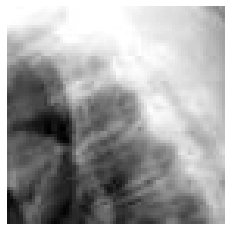

In [3]:
# image visulization
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

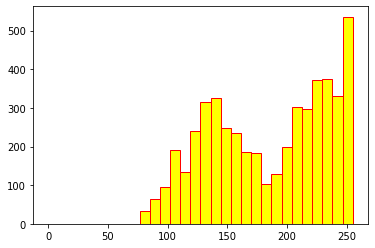

In [4]:
# image histogram
n=len(img); X=img.reshape(n*n)
plt.hist(X, range = (0, 255), bins = 30, color = 'yellow', edgecolor = 'red')
plt.show()

We can observe that the distribution of gray pixels values are not that concentrated. It ranges from about 70 to 256, with kind of two peaks at about 140 and 256.

### EM (self coded)

To remind, the EM algorithme is contructed by 4 main steps:

1. **Initialization**: fix a k, and initialize the paramters $\mu_k,\Sigma_k,\pi_k$ for each $k$
2. **Expectation Step**: compute the responsibilities matrix for each $i$ and $k$ where:
$$\gamma_{ik}=\frac{\pi_k \mathcal{N}(x_i;\mu_k,\Sigma_k)}{\sum_{j}\pi_j \mathcal{N}(x_i;\mu_j,\Sigma_j)}$$
3. **Maximazition Step**: for each cluster $k$, update the parameters which optimize the loglikelihood:
\begin{align}
\pi_k& = \frac{m_{k}}{m} \\
\mu_k & = \frac{1}{m_k} \sum_{i} r_{ik}x^{(i)} \\
\Sigma_k & = \frac{1}{m_k} \sum_{i} r_{ik}x^{(i)} (x^{(i)} - \mu_k)^T (x^{(i)} - \mu_k)
\end{align}
where $m_k=\sum_{i}\gamma_{ik}$ is the responsibility of cluster $k$, and $m=\sum_{k} m_k$

In [5]:
from numpy import linalg as LA
from scipy.stats import multivariate_normal

def E_Step(data,pi,mu,sigma):
    N,K= len(data),len(pi)

    r = np.empty((N,K))

    for k in range(K):
        r[:,k] = pi[k] * multivariate_normal.pdf(data,mu[k],sigma[k])

    return r / np.sum(r,axis=1).reshape(-1,1) # diveded by the cols sum as a normalization


def M_Step(data,r,pi,mu,sigma):
    K = r.shape[1]
    Nk = np.sum(r,axis=0); # print(Nk)
    N = np.sum(r)

    for k in range(K):
        pi[k] = Nk[k]/N
        mu[k] = np.average(data, axis=0, weights=r[:,k])
        sigma[k] = np.average((data - mu[k]) ** 2, axis=0, weights=r[:,k])

    return (pi, mu, sigma)


def log_p(data,K,pi,mu,sigma):
    N = len(data)
    log_p = 0

    for n in range(N):
        for k in range(K):
            log_p += pi[k] * multivariate_normal.pdf(data[n],mu[k],sigma[k])
    log_p += math.log(log_p)

    return log_p 


def EM(data,K=2):
    N = len(data)
    r = np.empty((N,K))

    # initialization (each clustering is supposed to be a normal distribution of 1D)
    mu = np.random.rand(K) * np.mean(data)
    sigma = np.random.rand(K) * np.var(data)
    pi = np.repeat(1./K,K) 

    while(True): 
        # E step: to conpute the responsibilities for each n and k
        r = E_Step(data,pi=pi,mu=mu,sigma=sigma)

        # M step: upgrade the parameters
        new_pi,new_mu,new_sigma = M_Step(data,r,pi=pi.copy(),mu=mu.copy(),sigma=sigma.copy())
        
        # check if converges
        if LA.norm(pi-new_pi)<1e-10 and LA.norm(mu-new_mu)<1e-10 and LA.norm(sigma-new_sigma)<1e-12:
            break

        pi = new_pi; mu = new_mu; sigma = new_sigma

    #log_pX.append(log_p(data,K,pi,mu,sigma))
    params = {'pi':new_pi, 'mu':new_mu, 'sigma':new_sigma}

    return params

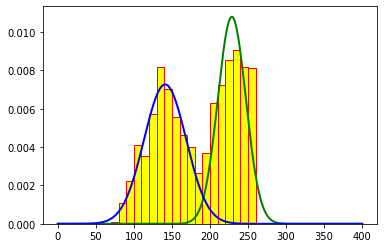

In [6]:
params = EM(data=X,K=2)

# display the res
range_ = np.linspace(0,400,400); mu = params['mu']; sigma_squared = params['sigma']; pi = params['pi']
density1 = scipy.stats.norm.pdf(range_,mu[0],math.sqrt(sigma_squared[0])) * pi[0]
density2 = scipy.stats.norm.pdf(range_,mu[1],math.sqrt(sigma_squared[1])) * pi[1]

plt.hist(X, range = (0, 400), normed=1, bins = 40, color = 'yellow', edgecolor = 'red')
plt.plot(range_,density1,lw=2,c='green')
plt.plot(range_,density2,lw=2,c='blue')
plt.show()

### A bimodal distribution assumption

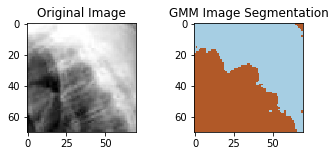

In [7]:
from sklearn import mixture
X2 = X.reshape(-1, 1)
modgmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
fitgmm=modgmm.fit(X2);predX=fitgmm.fit_predict(X2);imgGMMK2=predX.reshape(n,n)

#Display
figure = plt.figure(figsize=(5.5,2))
plt.xticks([], []); plt.yticks([], [])
ax = plt.subplot(1,2, 1); ax.imshow(img, cmap='gray'); ax.set_title('Original Image')
ax = plt.subplot(1,2, 2); ax.imshow(imgGMMK2, cmap='Paired'); ax.set_title('GMM Image Segmentation')
plt.show()

In [8]:
fitgmm.means_

array([[227.66090423],
       [139.41896295]])

In [9]:
fitgmm.covariances_

array([[[367.61971236]],

       [[693.66739881]]])

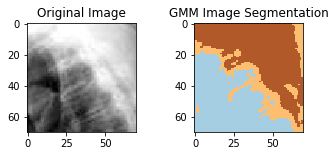

In [10]:
from sklearn import mixture
X2 = X.reshape(-1, 1)
modgmm = mixture.GaussianMixture(n_components=3, covariance_type='full')
fitgmm=modgmm.fit(X2);predX=fitgmm.fit_predict(X2);imgGMMK2=predX.reshape(n,n)

#Display
figure = plt.figure(figsize=(5.5,2))
plt.xticks([], []); plt.yticks([], [])
ax = plt.subplot(1,2, 1); ax.imshow(img, cmap='gray'); ax.set_title('Original Image')
ax = plt.subplot(1,2, 2); ax.imshow(imgGMMK2, cmap='Paired'); ax.set_title('GMM Image Segmentation')
plt.show()

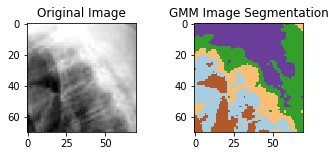

In [11]:
from sklearn import mixture
X2 = X.reshape(-1, 1)
modgmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
fitgmm=modgmm.fit(X2);predX=fitgmm.fit_predict(X2);imgGMMK2=predX.reshape(n,n)

#Display
figure = plt.figure(figsize=(5.5,2))
plt.xticks([], []); plt.yticks([], [])
ax = plt.subplot(1,2, 1); ax.imshow(img, cmap='gray'); ax.set_title('Original Image')
ax = plt.subplot(1,2, 2); ax.imshow(imgGMMK2, cmap='Paired'); ax.set_title('GMM Image Segmentation')
plt.show()

## Spectral Clustering

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler 
from matplotlib.colors import ListedColormap 
import pandas as pd
from scipy.spatial import distance_matrix
import math

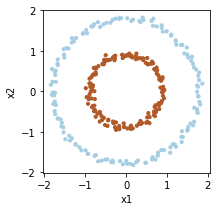

In [13]:
nsub = 150
my2circles = datasets.make_circles(n_samples=2*nsub, shuffle=False, factor=.5, noise=.025); X1,y1=my2circles
X1 = StandardScaler().fit_transform(X1)

figure = plt.figure(figsize=(3,3))
plt.scatter(X1[:, 0], X1[:, 1], s=10,c=y1, cmap='Paired')
plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

In [14]:
# Add nsub sample points drawn fromm a 2D Gaussian law with zero means, variance equaled to 0.001 and no correlation in the middle of the two circles
center = np.random.multivariate_normal([0,0],[[0.001,0],[0,0.001]],nsub)
X = np.concatenate((X1, center), axis=0)
y = np.concatenate((y1,[2]*150), axis=0)

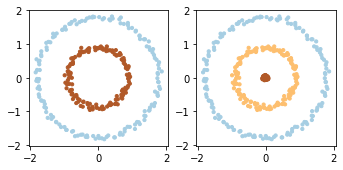

In [15]:
figure = plt.figure(figsize=(5.5,2.5))
ax = plt.subplot(1,2, 1); plt.scatter(X1[:, 0], X1[:, 1], s=10,c=y1, cmap='Paired');  
ax = plt.subplot(1,2, 2); plt.scatter(X[:, 0], X[:, 1], s=10,c=y, cmap='Paired'); 


In [16]:
 df = pd.DataFrame(X)

 # compute the euclidian distances between observations
 Z=distance_matrix(df.values, df.values)
 Z.shape

(450, 450)

In [17]:
from scipy.linalg import fractional_matrix_power

sigma = 0.1
W = np.exp(-Z**2/(2.*sigma**2))
I_n = np.eye(Z.shape[0])
D = np.zeros_like(Z); np.fill_diagonal(D, np.sum(W,1))

L = I_n - fractional_matrix_power(D, -0.5) @ W @ fractional_matrix_power(D, -0.5)

In [18]:
# L denotes the laplacian matrix, as previously defined
# E corresponds to diagonal eigen values matrix
# U_j the jth eigen vector, and V is its conjugate
U, E, V = np.linalg.svd(L, full_matrices=True)

# sort these based on the eigenvalues
vecs = U[:,np.argsort(E)]
vals = E[np.argsort(E)]

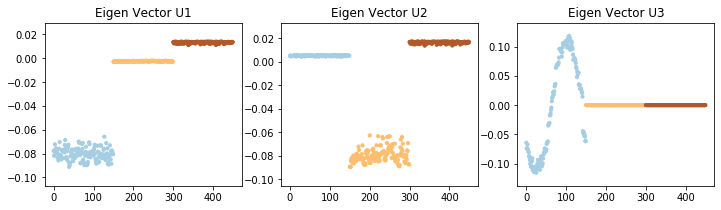

In [19]:
# display the first 3 non-zero eigen vectors
figure = plt.figure(figsize=(12,3))

for i in range(3):
    ax = plt.subplot(1,3,i+1)
    plt.scatter(list(range(X.shape[0])), vecs[:,i+1], s=10,c=y, cmap='Paired')
    plt.title("Eigen Vector U"+ str(i+1))

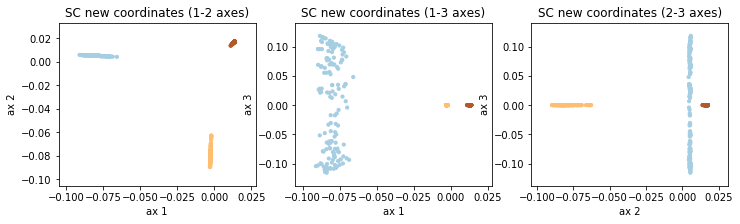

In [20]:
# Visualisation of the new representations (coordinates) of the observations based on the new Spectral Clustering representation (1 large circle contains 150 observations)
figure = plt.figure(figsize=(12,3))
ax = plt.subplot(1,3, 1); plt.scatter(vecs[:,1], vecs[:,2], s=10,c=y, cmap='Paired'); plt.title("SC new coordinates (1-2 axes)"); plt.xlabel("ax 1"); plt.ylabel("ax 2")
ax = plt.subplot(1,3, 2); plt.scatter(vecs[:,1], vecs[:,3], s=10,c=y, cmap='Paired'); plt.title("SC new coordinates (1-3 axes)"); plt.xlabel("ax 1"); plt.ylabel("ax 3")
ax = plt.subplot(1,3, 3); plt.scatter(vecs[:,2], vecs[:,3], s=10,c=y, cmap='Paired'); plt.title("SC new coordinates (2-3 axes)"); plt.xlabel("ax 2"); plt.ylabel("ax 3")
plt.show()

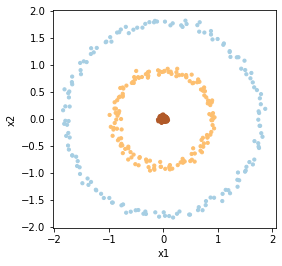

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(vecs[:,1:3])
colors = kmeans.labels_

# vis of results
figure = plt.figure(figsize=(4,4))
plt.scatter(X[:, 0], X[:, 1], s=10,c=colors, cmap='Paired')
plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

### Kmeans with raw data

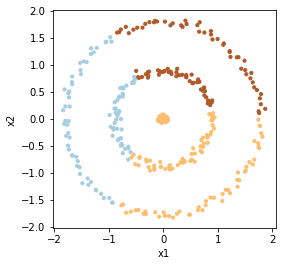

In [22]:
kmeans = KMeans(n_clusters=3).fit(X)
colors = kmeans.labels_

# vis of results
figure = plt.figure(figsize=(4,4))
plt.scatter(X[:, 0], X[:, 1], s=10,c=colors, cmap='Paired')
plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

It is hard for kmeans to seperate non-linear distribution of data.

### Impact of the SC hyperparameter $\sigma$

In [23]:
# rearrange the previous clustering process as a function:

def spectral_clustering(sigma,data):
    df = pd.DataFrame(data)
    Z=distance_matrix(df.values, df.values)
    
    W = np.exp(-Z**2/(2.*sigma**2))
    D = np.zeros_like(Z); np.fill_diagonal(D, np.sum(W,1))
    L = np.eye(Z.shape[0]) - fractional_matrix_power(D, -0.5) @ W @ fractional_matrix_power(D, -0.5)

    # SVD decomposition
    U, E, V = np.linalg.svd(L, full_matrices=True)

    # sort these based on the eigenvalues
    vecs = U[:,np.argsort(E)]
    vals = E[np.argsort(E)]

    kmeans = KMeans(n_clusters=3).fit(vecs[:,1:3])
    return kmeans.labels_

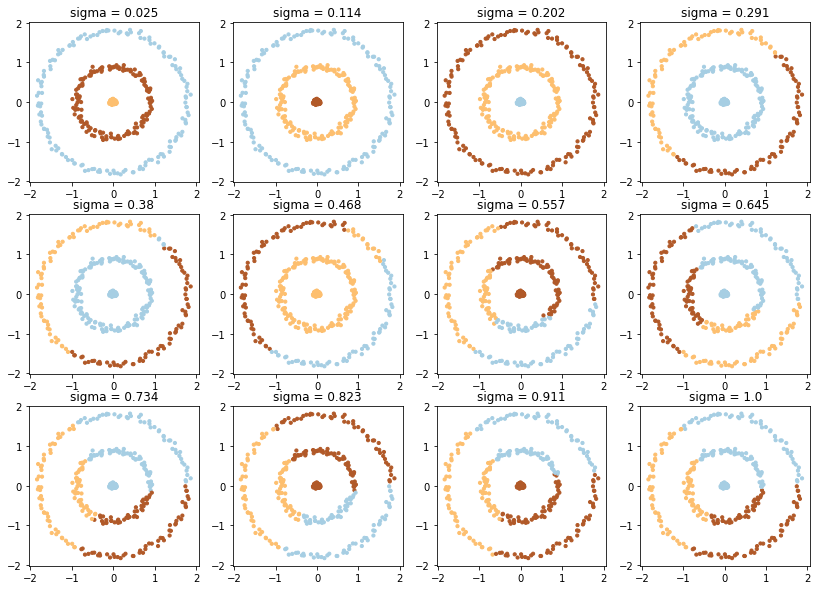

In [24]:
figure = plt.figure(figsize=(14,10))

for i,sigma in enumerate(np.linspace(0.025, 1, 12)):
    ax = plt.subplot(3,4,i+1)
    plt.scatter(X[:, 0], X[:, 1], s=10,c=spectral_clustering(sigma=sigma,data=X), cmap='Paired'); 
    plt.title("sigma = " + str(round(sigma,3)))

By varying $\sigma$ from 0.05 to 1 we can find that, the results are very sensitive to the value of sigma since a trivial modification may lead to a bad clustering. In our case, we can set $\sigma$ equals to a value from $[0.1, 0.2]$.

### implementation of sklearn

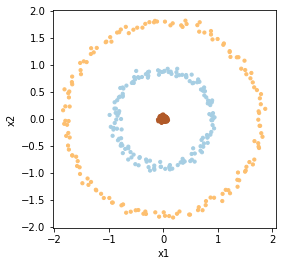

In [25]:
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=3,gamma=10,assign_labels="discretize").fit(X)

figure = plt.figure(figsize=(4,4))
plt.scatter(X[:, 0], X[:, 1], s=10,c=clustering.labels_, cmap='Paired')
plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

In [26]:
clustering.affinity_matrix_

array([[1.00000000e+00, 7.86924419e-01, 8.57111627e-01, ...,
        1.11953425e-13, 1.34034890e-14, 4.25233858e-14],
       [7.86924419e-01, 1.00000000e+00, 9.89220373e-01, ...,
        7.81378838e-14, 9.16087677e-15, 2.64841587e-14],
       [8.57111627e-01, 9.89220373e-01, 1.00000000e+00, ...,
        6.00296998e-14, 6.97612371e-15, 2.06980536e-14],
       ...,
       [1.11953425e-13, 7.81378838e-14, 6.00296998e-14, ...,
        1.00000000e+00, 9.63901414e-01, 9.79593903e-01],
       [1.34034890e-14, 9.16087677e-15, 6.97612371e-15, ...,
        9.63901414e-01, 1.00000000e+00, 9.79875745e-01],
       [4.25233858e-14, 2.64841587e-14, 2.06980536e-14, ...,
        9.79593903e-01, 9.79875745e-01, 1.00000000e+00]])